In [ ]:
# import libraries
import pandas as pd
import numpy as np


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Datasets/emotion_nlp/emotion_train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/emotion_nlp/emotion_test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
# number of unique sentiments
#np.unique(df_train['Sentiment'])
# or
df_train.Sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

In [ ]:
df_test.Sentiment.value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Sentiment, dtype: int64

In [ ]:
# Label encoding the target of training set
df_train['Sentiment'].replace("anger",0,inplace = True)
df_train['Sentiment'].replace("fear",1,inplace = True)
df_train['Sentiment'].replace("joy",2,inplace = True)
df_train['Sentiment'].replace("love",3,inplace = True)
df_train['Sentiment'].replace("sadness",4,inplace = True)
df_train['Sentiment'].replace("surprise",5,inplace = True)

# Label encoding the target of testing set
df_test['Sentiment'].replace("anger",0,inplace = True)
df_test['Sentiment'].replace("fear",1,inplace = True)
df_test['Sentiment'].replace("joy",2,inplace = True)
df_test['Sentiment'].replace("love",3,inplace = True)
df_test['Sentiment'].replace("sadness",4,inplace = True)
df_test['Sentiment'].replace("surprise",5,inplace = True)

In [ ]:
df_train.head(3)

,Input,Sentiment
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0


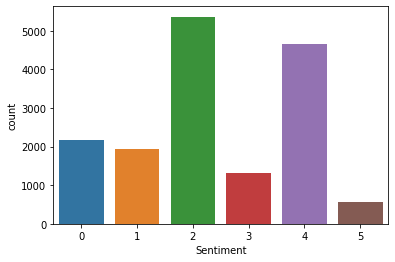

In [ ]:
import seaborn as sns
sns.countplot(x="Sentiment",data=df_train)

In [ ]:
df_test.Sentiment.value_counts()

2    695
4    581
0    275
1    224
3    159
5     66
Name: Sentiment, dtype: int64

In [ ]:
# Dealing with missing values in training set
df_train.isnull().sum()

Input        0
Sentiment    0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Input      16000 non-null  object
 1   Sentiment  16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [ ]:
# Creating the input and output variables
x = df_train["Input"]
y = df_train["Sentiment"]

print(x.shape,y.shape)

(16000,) (16000,)


In [ ]:
message = x.copy()

In [ ]:
message [0]

'i didnt feel humiliated'

## TEXT PRE-PROCESSING

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ps = PorterStemmer()

In [ ]:
# Creat the corpus of text
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
corpus[1]

'go feel hopeless damn hope around someon care awak'

In [ ]:
from tensorflow import keras
from keras_preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Create one hot representation of the text
voc_size = 10000
one_hot_representation = [one_hot(words,voc_size) for words in corpus]

one_hot_representation[1]

[7918, 4112, 9268, 6657, 9866, 5285, 2736, 6124, 3473]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Create same length inputs
sent_length = 20
embedded_doc = pad_sequences(one_hot_representation,padding='pre',maxlen=sent_length)
embedded_doc[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       7918, 4112, 9268, 6657, 9866, 5285, 2736, 6124, 3473], dtype=int32)

## MODEL BUILDING

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,Dense,Dropout,LSTM,Bidirectional

In [ ]:
dimension = 40
model = Sequential()
model.add(Embedding(voc_size,dimension,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.001) ,metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            400000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
final_x = np.array(embedded_doc)
final_y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, test_size=0.33, random_state=42, stratify = final_y)

model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
168/168 [==============================] - 13s 57ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 2/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 3/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 4/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 5/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 6/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 7/10
168/168 [==============================] - 9s 53ms/step - loss: 0.0000e+00 - accur

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, dimension),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dimension,
              return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dimension)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
])

model2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.001) ,metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            400000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model2.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
168/168 [==============================] - 18s 66ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 2/10
168/168 [==============================] - 10s 57ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 3/10
168/168 [==============================] - 10s 57ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 4/10
168/168 [==============================] - 10s 57ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 5/10
168/168 [==============================] - 10s 58ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 6/10
168/168 [==============================] - 9s 57ms/step - loss: 0.0000e+00 - accuracy: 0.1211 - val_loss: 0.0000e+00 - val_accuracy: 0.1210
Epoch 7/10
168/168 [==============================] - 10s 57ms/step - loss: 0.0000e+00 - 